In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
# import stockstats as st

import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
# uncomment if you need upload data with Yahoo Finance
# spy = yf.Ticker ("SPY") 
# data = pd.DataFrame(spy.history(period="max"))
# data.to_csv('data.csv')

In [3]:
data = pd.read_csv('data.csv', index_col='Date')

In [4]:
data["MA12"] = data["Open"].rolling(window=12).mean()
data["MA26"] = data["Open"].rolling(window=26).mean()
data["MA50"] = data["Open"].rolling(window=50).mean()
data["MA100"] = data["Open"].rolling(window=100).mean()
data["MA200"] = data["Open"].rolling(window=200).mean() # possibly use data.iloc[:,0] instead data["Open"]
data["MA13"] = data["Open"].rolling(window=13).mean()

data["std12"] = data["Open"].rolling(window=12).std()
data["std26"] = data["Open"].rolling(window=26).std()
data["std50"] = data["Open"].rolling(window=50).std()
data["std100"] = data["Open"].rolling(window=100).std()
data["std200"] = data["Open"].rolling(window=200).std()

data["% day (o&c)"] = (data["Close"] / data["Open"] - 1)*100 # change in % between price open and price close
data["% day (l&h)"] = (data["High"] / data["Low"] - 1)*100 # change in % between price low and price high
data["% change (o&c) & (l&h)"] = (data["% day (l&h)"] / ((data["% day (o&c)"]**2)**0.5) - 1)*100  # change in %
# between (price open/price close) and (price low/price high)

data["% day (ma12&ma26) (cd 12&26)"] = (data["MA12"] / data["MA26"] - 1)*100
data["% day (ma26&ma50) (cd 26&50)"] = (data["MA26"] / data["MA50"] - 1)*100
data["% day (ma50&ma100) (cd 50&100)"] = (data["MA50"] / data["MA100"] - 1)*100
data["% day (ma100&ma200) (cd 100&200)"] = (data["MA100"] / data["MA200"] - 1)*100
data["% day (ma12&ma50) (cd 12&50)"] = (data["MA12"] / data["MA50"] - 1)*100
data["% day (ma12&ma100) (cd 12&100)"] = (data["MA12"] / data["MA100"] - 1)*100
data["% day (ma12&ma200) (cd 12&200)"] = (data["MA12"] / data["MA200"] - 1)*100

# print(data.iloc[6715:,])
print(data)

                  Open        High         Low       Close     Volume  \
Date                                                                    
1993-01-29   25.818120   25.818120   25.689672   25.799770    1003200   
1993-02-01   25.818125   25.983273   25.818125   25.983273     480500   
1993-02-02   25.964916   26.056665   25.909866   26.038315     201300   
1993-02-03   26.075019   26.331916   26.056669   26.313566     529400   
1993-02-04   26.405305   26.478704   26.111709   26.423655     531500   
...                ...         ...         ...         ...        ...   
2021-07-16  436.010010  436.059998  430.920013  431.339996   75784700   
2021-07-19  426.190002  431.410004  421.970001  424.970001  147987000   
2021-07-20  425.679993  432.420013  424.829987  431.059998   99501600   
2021-07-21  432.339996  434.700012  431.010010  434.549988   64623000   
2021-07-22  434.739990  435.720001  433.690002  435.459991   47820500   

            Dividends  Stock Splits        MA12   

In [5]:
interval_days = 1000
row_start = 7172 - interval_days
row_end = 7172

In [6]:
# below is the Elder Impulse systems code
# https://earnfo.com/elder-impulse-system/
# https://library.tradingtechnologies.com/trade/chrt-ti-elder-impulse-system.html

# pd.options.display.max_columns = None # show all columns when they are not visible
# pd.options.display.max_rows = None # show all rows when they are not visible

data["EIS"] = ""
iloc_cd = data.columns.get_loc("% day (ma12&ma26) (cd 12&26)") #reserch number columns "% day (ma12&ma26)"
iloc_eis = data.columns.get_loc("EIS") #reserch number columns "EIS"
iloc_close = data.columns.get_loc("Close") #reserch number columns "Close"
iloc_ma13 = data.columns.get_loc("MA13") #reserch number columns "MA13"

for index in range(1, 7172):
    if (data.iloc[index-1, iloc_cd] < data.iloc[index, iloc_cd]) and (
        data.iloc[index, iloc_close] > data.iloc[index, iloc_ma13]):
        data.iloc[index, iloc_eis] = 3 # growth signal EFI 
    elif (data.iloc[index-1, iloc_cd] > data.iloc[index, iloc_cd]) and (
        data.iloc[index, iloc_close] < data.iloc[index, iloc_ma13]):
        data.iloc[index, iloc_eis] = 1 # drop signal EFI
    else: data.iloc[index, iloc_eis] = 2 # signal neutral EFI
        
# print (data.iloc[6865:,])
# data.head(1).append(data.tail(50)) # show first and last values
# data.tail(31) #show last values

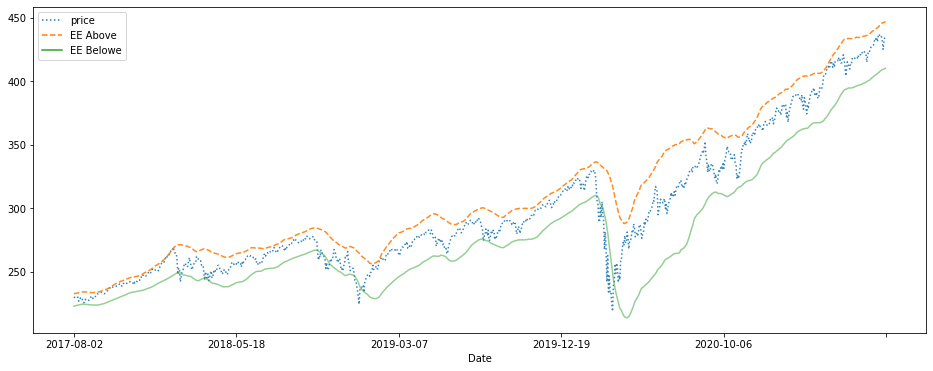

In [7]:
# below is the Elder Envelope code

data["EE centerline"] = data["MA26"]
data["EE myvar"] = ""

iloc_myvar = data.columns.get_loc("EE myvar") #reserch number columns "myvar"
iloc_high = data.columns.get_loc("High")
iloc_low = data.columns.get_loc("Low")
iloc_centerline = data.columns.get_loc("EE centerline")

for index in range(13, 7172):
    if ((data.iloc[index, iloc_close]-data.iloc[index, iloc_centerline]) >= 0):
        data.iloc[index, iloc_myvar] = max((data.iloc[index, iloc_high]-data.iloc[index, iloc_centerline]), (data.iloc[index, iloc_low]-data.iloc[index, iloc_centerline]))
    else: data.iloc[index, iloc_myvar] = max((data.iloc[index, iloc_high]-data.iloc[index, iloc_centerline]), (data.iloc[index, iloc_low]-data.iloc[index, iloc_centerline]))  

data["EE myvars"] = data.iloc[13:, iloc_myvar] * data.iloc[13:, iloc_myvar]
data["EE mymov"] = (data["EE myvars"].rolling(window=100).mean())**0.5

data["EE Above"] = data["EE centerline"] + (data["EE mymov"] * 2)
data["EE Belowe"] = data["EE centerline"] - (data["EE mymov"] * 2)

iloc_ea = data.columns.get_loc("EE Above") #reserch number columns "Envelope Above"
iloc_eb = data.columns.get_loc("EE Belowe") #reserch number columns "Envelope Belowe"

data1 = pd.DataFrame({'price': data.iloc[row_start:row_end, iloc_close],
                    'EE Above': data.iloc[row_start:row_end, iloc_ea],
                    'EE Belowe': data.iloc[row_start:row_end, iloc_eb]})
ax1 = data1.plot(style=[':', '--', '-'], figsize=(16, 6))
ax1.lines[0].set_alpha(0.9)
ax1.lines[1].set_alpha(0.9)
ax1.lines[2].set_alpha(0.5)

In [8]:
# below is the ATR channel

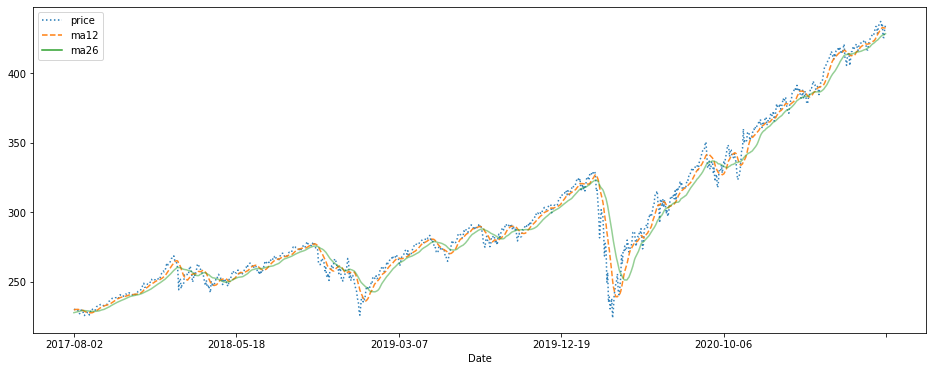

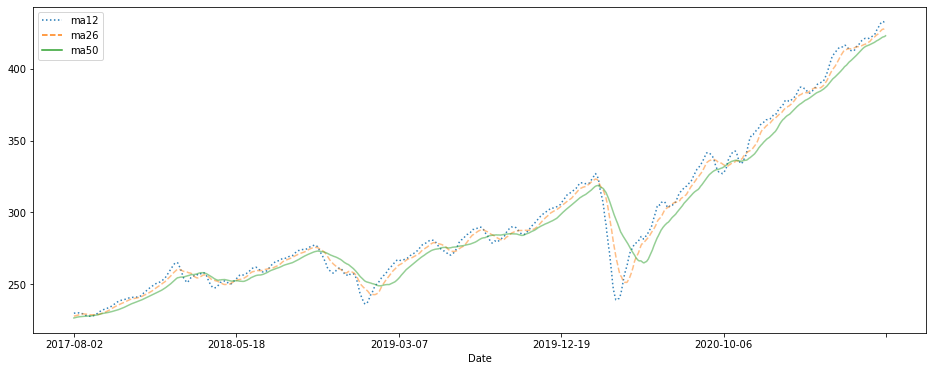

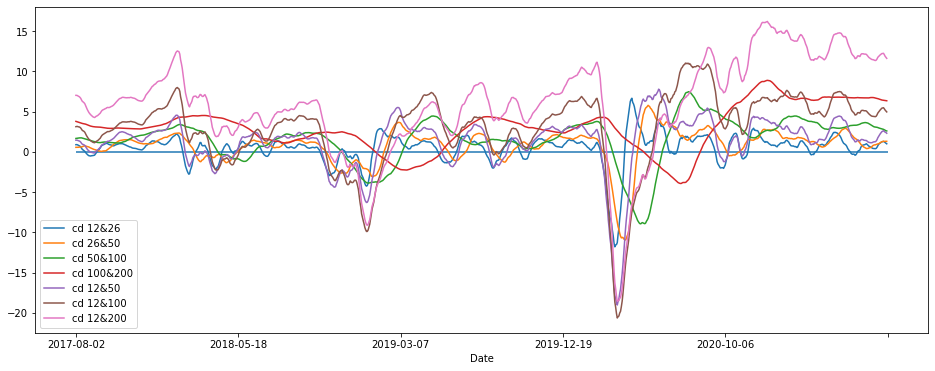

In [9]:

data1 = pd.DataFrame({'price': data.iloc[row_start:row_end, 0],
                    'ma12': data.iloc[row_start:row_end, 7],
                    'ma26': data.iloc[row_start:row_end, 8]})
ax1 = data1.plot(style=[':', '--', '-'], figsize=(16, 6))
ax1.lines[0].set_alpha(0.9)
ax1.lines[1].set_alpha(0.9)
ax1.lines[2].set_alpha(0.5)


data2 = pd.DataFrame({'ma12': data.iloc[row_start:row_end, 7],
                    'ma26': data.iloc[row_start:row_end, 8],
                    'ma50': data.iloc[row_start:row_end, 9]})
ax2 = data2.plot(style=[':', '--'], figsize=(16, 6))
ax2.lines[0].set_alpha(0.9)
ax2.lines[1].set_alpha(0.5)
ax2.lines[2].set_alpha(0.5)


iloc_cd = data.columns.get_loc("% day (ma12&ma26) (cd 12&26)") #reserch number columns "% day (ma12&ma26)"
iloc_cd2 = data.columns.get_loc("% day (ma26&ma50) (cd 26&50)")
iloc_cd3 = data.columns.get_loc("% day (ma50&ma100) (cd 50&100)")
iloc_cd4 = data.columns.get_loc("% day (ma100&ma200) (cd 100&200)")
iloc_cd5 = data.columns.get_loc("% day (ma12&ma50) (cd 12&50)")
iloc_cd6 = data.columns.get_loc("% day (ma12&ma100) (cd 12&100)")
iloc_cd7 = data.columns.get_loc("% day (ma12&ma200) (cd 12&200)")
data3 = pd.DataFrame({'cd 12&26': data.iloc[row_start:row_end, iloc_cd],
                     'cd 26&50': data.iloc[row_start:row_end, iloc_cd2],
                     'cd 50&100': data.iloc[row_start:row_end, iloc_cd3],
                     'cd 100&200': data.iloc[row_start:row_end, iloc_cd4],
                     'cd 12&50': data.iloc[row_start:row_end, iloc_cd5],
                     'cd 12&100': data.iloc[row_start:row_end, iloc_cd6],
                     'cd 12&200': data.iloc[row_start:row_end, iloc_cd7]})
ax3 = data3.plot(figsize=(16, 6))
ax3.hlines(0, 0, interval_days)

([<matplotlib.axis.XTick at 0x7f9359857370>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

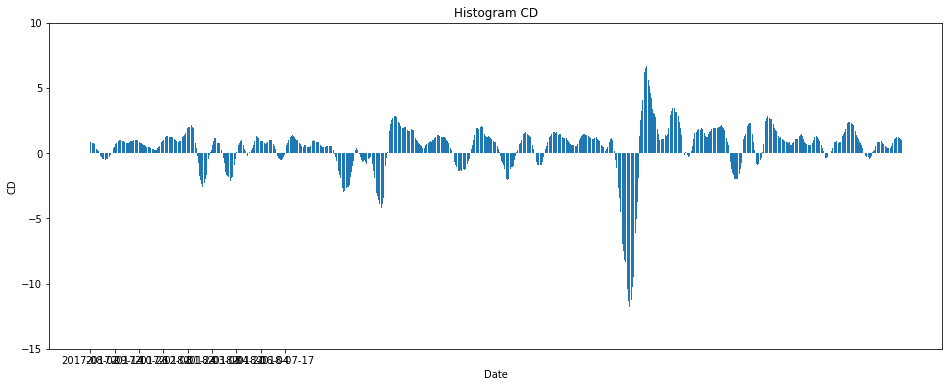

In [10]:
iloc_cd = data.columns.get_loc("% day (ma12&ma26) (cd 12&26)") #reserch number columns "% day (ma12&ma26)"
data_cd = pd.DataFrame({'cd': data.iloc[row_start:row_end, iloc_cd]})

x_cd=data_cd.index.values
y_cd=data_cd['cd'].values[:]

fig, ax = plt.subplots()
plt.title("Histogram CD")
plt.xlabel("Date")
plt.ylabel("CD")
ax.bar(x_cd, y_cd) # select the variables for the axis x & y
fig.set_figwidth(16)
fig.set_figheight(6)
plt.yticks(np.arange(-15, 15, 5)) # scale interval setting: ymin, ymax, yinterval
plt.xticks(np.arange(0, 250, 30)) # scale interval setting: ymin, ymax, yinterval

In [11]:
print(data.iloc[row_start:row_end, 0].mean()) #where mayby do line zero on grah

296.8848269372587


In [12]:
# rename columns
# data.rename(columns = {'Open' : 'open', 'High' : 'high', 'Low' : 'low',
#                        'Close' : 'close', 'Volume' : 'volume'}, inplace = True)
# data.columns
# data = data[['open', 'close', 'high', 'low', 'volume']]

# print(data.iloc[200:,])

In [13]:
# %matplotlib inline
# data = data['Open']
# data.plot()

In [14]:
# rolling = data.rolling(200, center=True)
# data1 = pd.DataFrame({'input': data.iloc[200:,],
#                     'one-year rolling_mean': rolling.mean(),
#                     'one-year rolling_std': rolling.std()})
# ax = data1.plot(style=['-', '--', ':'])
# ax.lines[0].set_alpha(0.3)

In [15]:
# pd.options.display.max_columns = None # show all columns when they are not visible
# pd.options.display.max_rows = None # show all rows when they are not visible
# uncomment code belowe to save data set
# data.iloc[199:, :].to_csv('data_set.csv')